# Homework - Deep learning for image classification


Let's train network to classify images from Tiny ImageNet!

Your homework contains three parts:

1. Make yourself familiar with ordinary training script structure and train good old vgg-like network
2. Improve quality with resnet-like network
3. Improve quality with test-time augmentation

But first of all let's take a look on data

# Tiny ImageNet dataset
In this homework we shall focus on the image recognition problem on Tiny Image Net dataset. This dataset contains
* 100k images of shape 3x64x64
* 200 different classes: snakes, spiders, cats, trucks, grasshopper, gull, etc.

In fact, it is a subset of ImageNet dataset with 4x downscaled images.

## Image examples



<tr>
    <td> <img src="https://github.com/yandexdataschool/Practical_DL/blob/sem3spring2019/week03_convnets/tinyim3.png?raw=1" alt="Drawing" style="width:90%"/> </td>
    <td> <img src="https://github.com/yandexdataschool/Practical_DL/blob/sem3spring2019/week03_convnets/tinyim2.png?raw=1" alt="Drawing" style="width:90%"/> </td>
</tr>


<tr>
    <td> <img src="https://github.com/yandexdataschool/Practical_DL/blob/sem3spring2019/week03_convnets/tiniim.png?raw=1" alt="Drawing" style="width:90%"/> </td>
</tr>

## Step 0 - data loading

In [1]:
#!S:bash
# if you are in colab, just add '!' in the start of the following line
!wget --no-check-certificate 'https://raw.githubusercontent.com/yandexdataschool/deep_vision_and_graphics/fall21/homework01/tiny_img.py' -O tiny_img.py
!wget --no-check-certificate 'https://raw.githubusercontent.com/yandexdataschool/deep_vision_and_graphics/fall21/homework01/tiny_img_dataset.py' -O tiny_img_dataset.py

--2024-10-05 19:48:03--  https://raw.githubusercontent.com/yandexdataschool/deep_vision_and_graphics/fall21/homework01/tiny_img.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 813 [text/plain]
Saving to: ‘tiny_img.py’

tiny_img.py         100%[===================>]     813  --.-KB/s    in 0s      

2024-10-05 19:48:03 (72.2 MB/s) - ‘tiny_img.py’ saved [813/813]

--2024-10-05 19:48:03--  https://raw.githubusercontent.com/yandexdataschool/deep_vision_and_graphics/fall21/homework01/tiny_img_dataset.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response

In [2]:

#!L
from tiny_img import download_tinyImg200
data_path = '.'
download_tinyImg200(data_path)

Dataset was downloaded to './tiny-imagenet-200.zip'
Extract downloaded dataset to '.'


## Part 1. Training script structure and vgg-like network

In order to train a neural network for a specific task you should write code for 4 task-specific blocks and for one task-independed block:
1. data loader (data provider) - how to load and augment data for nn training
2. neural network architecture - what will be trained
3. loss function (+ auxilary metrics on train and validation set) - how to check neural network quality
4. optiimzer and training schedule - how neural network will be trained
5. "Train loop" - what exactly to do for each batch, how often to check validation error, how often to save network and so on. This code could be written in general way and reused between different training scripts


In [3]:
#!L
import torch
import torchvision
from torchvision import transforms
import tqdm

def get_computing_device():
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu')
    return device

device = get_computing_device()
print(f"Our main computing device is '{device}'")

Our main computing device is 'cuda:0'


### 1.1 Data loader and data augmentation
Normally there are two connected abstractions for data manipulation:
- Dataset (`torch.utils.data.Dataset` and its subclasses from `torchvision.datasets`) - some black-box that keeps and preprocesses separate elements of dataset. In particular, single sample augmentations live on this level usually.
- DataLoader (`torch.utils.data.DataLoader`) - structure that combines separate elements in batch.

Let's deal with training dataset. Here are some simple augmentations that we are going to use in our experiments:

In [4]:
train_trainsforms = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.RandomRotation(5),
     # YOUR CODE : examine torchvision.transforms package, find transformation for color jittering
     # and add it with proper parameters.
     transforms.ColorJitter()
     # you may add any other transforms here
    ]
)

For training dataset we will use custom dataset that will keep all training data in RAM. If your amount of RAM memory is low, you can use `torchvision.datasets.ImageFolder()` instead.

In [5]:
#!L
import tiny_img_dataset
# you may use torchvision.datasets.ImageFolder() with the same parameters for loading train dataset
train_dataset = tiny_img_dataset.TinyImagenetRAM('tiny-imagenet-200/train', transform=train_trainsforms)

tiny-imagenet-200/train: 100%|██████████| 200/200 [01:27<00:00,  2.28it/s]


Now validation. Take a look at `tiny-imagenet-200/val` folder and compare it with `tiny-imagenet-200/train`. Looks different, right? So we can't use `TinyImagenetRAM` for loading the validation set. Let's write a custom dataset instead but with the same behavior like `TinyImagenetRAM`.

In [6]:
from torch.utils.data import Dataset
import os
from PIL import Image

class TinyImagenetValDataset(Dataset):
    def __init__(self, root, transform=transforms.ToTensor()):
        super().__init__()

        self.root = root
        with open(os.path.join(root, 'val_annotations.txt')) as f:
            annotations = []
            for line in f:
                img_name, class_label = line.split('\t')[:2]
                annotations.append((img_name, class_label))

        # 1. define self.classes - list of sorted class labels from annotations
        # it should look like self.classes from "TinyImagenetRAM"
        # YOUR CODE
        self.classes = sorted(list(set([item[1] for item in annotations])))

        assert len(self.classes) == 200, len(self.classes)
        assert all(self.classes[i] < self.classes[i+1] for i in range(len(self.classes)-1)), 'classes should be ordered'
        assert all(isinstance(elem, type(annotations[0][1])) for elem in self.classes), 'your just need to reuse class_labels'

        # 2. self.class_to_idx - dict from class label to class index
        self.class_to_idx = {item: index for index, item in enumerate(self.classes)}

        self.transform = transform

        self.images, self.targets = [], []
        for img_name, class_name in tqdm.tqdm(annotations, desc=root):
            img_name = os.path.join(root, 'images', img_name)
            # 3. load image and store it in self.images (your may want to use tiny_img_dataset.read_rgb_image)
            # store the class index in self.targets
            # YOUR CODE
            image = tiny_img_dataset.read_rgb_image(img_name)

            assert image.shape == (64, 64, 3), image.shape
            self.images.append(Image.fromarray(image))
            self.targets.append(self.class_to_idx[class_name])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        # take image and its target label from "self.images" and "self.targets",
        # transform the image using self.transform and return the transformed image and its target label

        # YOUR CODE
        image = self.images[index]
        image = self.transform(image)
        target = self.targets[index]

        return image, target

Let's finally load validation dataset. Normally you don't need to augment validation data.

In [7]:
val_dataset = TinyImagenetValDataset('tiny-imagenet-200/val', transform=transforms.ToTensor())

assert all(train_dataset.classes[i] == val_dataset.classes[i] for i in range(200)), \
    'class order in train and val datasets should be the same'
assert all(train_dataset.class_to_idx[elem] == val_dataset.class_to_idx[elem] for elem in train_dataset.classes), \
    'class indices should be the same'

tiny-imagenet-200/val: 100%|██████████| 10000/10000 [00:09<00:00, 1084.67it/s]


For the most cases the default `DataLoader` will be good enough.

In [8]:
#!L
batch_size = 64
train_batch_gen = torch.utils.data.DataLoader(train_dataset,
                                              batch_size=batch_size,
                                              shuffle=True,
                                              num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [9]:
#!L
val_batch_gen = torch.utils.data.DataLoader(val_dataset,
                                            batch_size=batch_size,
                                            shuffle=False,
                                            num_workers=4)

### 1.2 Neural network definition

"VGG-like network" usually means that the network is a sequence of convolutions with MaxPooling for downsampling. Here is a table from the original paper ["Very Deep Convolutional Networks for Large-Scale Image Recognition"](https://arxiv.org/abs/1409.1556) that describes classical configurations of VGG networks (often referred as VGG-A, VGG-B and so on using column name as an identificator or as VGG16, VGG19 and so on using amount of layers as an identificator)
![image.png](https://pytorch.org/assets/images/vgg.png)

These network configurations were designed for ImageNet dataset. Since images in tiny-imagenet are 4x downsampled, we are going to design our own configuration by reducing: 1) amount of layers; 2) amount of neurons in layers; 3) amount of maxpooling layers which downsample feature maps

Our network config will be [Conv(16), Conv(16), MaxPool] + [Conv(32), Conv(32), MaxPool] + [Conv(64), Conv(64), MaxPool] + [Conv(128), Conv(128)] + [GlobalAveragePooling] + [FC(200) + softmax]

We use Conv(128) and GlobalAveragePooling instead of image flattening and FC layers for reducing the amount of parameters.

In [10]:
#!L
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

And one more thing. VGG was designed before BatchNormalization was introduced. Nowadays it will be stupid if we don't use batch normalization in our network. So let's define simple module containing convolution, batch norm and relu in it and build our network using this module. Here is also implementation of GlobalAveragePooling given for you as example of custom module.

In [11]:
#!L
class GlobalAveragePool(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
    def forward(self, x):
        return torch.mean(x, dim=self.dim)


class ConvBNRelu(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding='same'):
        super().__init__()

        # YOUR CODE: define vars for convolution, batchnorm, relu

        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, x):
        # YOUR CODE: sequentially apply convolution, batchnorm, relu to 'x'
        transforms = [self.conv, self.bn, self.relu]
        for transform in transforms:
            x = transform(x)
        return x


def create_vgg_like_network(config=None):
    """
    Creates VGG like network according to config
    """
    model = nn.Sequential()

    default_config = [[16,16], [32, 32], [64, 64], [128, 128]]
    config = config or default_config

    in_channels = 3
    for block_index in range(len(config)):
        for layer_index_in_block in range(len(config[block_index])):
            out_channels = config[block_index][layer_index_in_block]

            # YOUR CODE: add ConvBNRelu module to model
            model.add_module(f'ConvBNRelu_{block_index}_{layer_index_in_block}', ConvBNRelu(in_channels, out_channels, kernel_size=3, stride=1, padding=1))
            in_channels = out_channels

        if block_index != len(config) - 1:
            model.add_module(f'mp_{block_index}', nn.MaxPool2d(3, stride=2))

    model.add_module('pool', GlobalAveragePool(dim=(2,3)))
    model.add_module('logits', nn.Linear(out_channels, 200))
    return model

Here are our model created!

In [12]:
model = create_vgg_like_network()
model = model.to(device)

### 1.3 Loss function definition

Usually cross-entropy (negative log-likelihood) is used as loss function for image classification.

In [13]:
#!L
def compute_loss(predictions, gt):
    return F.cross_entropy(predictions, gt).mean()

### 1.4 Optimizer and training schedule

Let's train our network using Adam with default parameters.

For training by `torch.optim.SGD` you usually have to define training schedule - a way how to decrease learning rate during training. But since in adam all the gradients are scaled on their second momentum, the effect of a good training schedule is not so critical for training as in SGD. So we are going to act like lazy data scientists and will not decrease learning rate at all. But you may play with scheduling using for example `torch.optim.lr_scheduler.ExponentialLR`, see the [documentation](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate) with explanation how to use it.

In [14]:
opt = torch.optim.Adam(model.parameters())

### 1.5 Training loop

Let's combine the previously defined things together.

In [17]:
import numpy as np
import time


def eval_model(model, data_generator):
    accuracy = []
    model.train(False) # disable dropout / use averages for batch_norm
    with torch.no_grad():
        for X_batch, y_batch in data_generator:
            X_batch = X_batch.to(device)
            logits = model(X_batch)
            y_pred = logits.max(1)[1].data
            accuracy.append(np.mean((y_batch.cpu() == y_pred.cpu()).numpy()))
    return np.mean(accuracy)


def train_model(model, optimizer, train_data_generator):
    train_loss = []
    model.train(True) # enable dropout / batch_norm training behavior
    for (X_batch, y_batch) in tqdm.tqdm(train_data_generator):
        opt.zero_grad()

        # forward
        # YOUR CODE: move X_batch, y_batch to 'device', compute model outputs on X_batch,
        # run `compute_loss()` function
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        predictions = model(X_batch)
        loss = compute_loss(predictions, y_batch)

        # backward
        loss.backward()
        optimizer.step()

        # metrics
        train_loss.append(loss.cpu().data.numpy())
    return np.mean(train_loss)


def train_loop(model, optimizer, train_data_generator, val_data_generator, num_epochs):
    """
    num_epochs - total amount of full passes over training data
    """
    for epoch in range(num_epochs):
        start_time = time.time()

        train_loss = train_model(model, optimizer, train_data_generator)

        val_accuracy = eval_model(model, val_data_generator)

        # Then we print the results for this epoch:
        print("Epoch {} of {} took {:.3f}s".format(epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_accuracy * 100))

### 1.6 Training

All the preparation is done, time to run the training!

Normally after training for 30 epochs you should get a neural network that predicts labels with >40% accuracy here.

In [ ]:
train_loop(model, opt, train_batch_gen, val_batch_gen, num_epochs=30)

100%|██████████| 1563/1563 [02:02<00:00, 12.77it/s]


Epoch 1 of 30 took 125.904s
  training loss (in-iteration): 	4.240826
  validation accuracy: 			12.86 %


100%|██████████| 1563/1563 [01:55<00:00, 13.56it/s]


Epoch 2 of 30 took 118.748s
  training loss (in-iteration): 	3.541786
  validation accuracy: 			16.99 %


100%|██████████| 1563/1563 [01:56<00:00, 13.40it/s]


Epoch 3 of 30 took 120.118s
  training loss (in-iteration): 	3.228161
  validation accuracy: 			24.98 %


100%|██████████| 1563/1563 [01:51<00:00, 14.03it/s]


Epoch 4 of 30 took 114.744s
  training loss (in-iteration): 	3.025041
  validation accuracy: 			28.48 %


100%|██████████| 1563/1563 [02:01<00:00, 12.88it/s]


Epoch 5 of 30 took 129.140s
  training loss (in-iteration): 	2.872708
  validation accuracy: 			29.92 %


100%|██████████| 1563/1563 [01:55<00:00, 13.50it/s]


Epoch 6 of 30 took 119.231s
  training loss (in-iteration): 	2.756686
  validation accuracy: 			32.32 %


100%|██████████| 1563/1563 [01:59<00:00, 13.04it/s]


Epoch 7 of 30 took 123.371s
  training loss (in-iteration): 	2.663170
  validation accuracy: 			34.12 %


100%|██████████| 1563/1563 [01:55<00:00, 13.56it/s]


Epoch 8 of 30 took 118.753s
  training loss (in-iteration): 	2.583548
  validation accuracy: 			34.66 %


100%|██████████| 1563/1563 [01:57<00:00, 13.32it/s]


Epoch 9 of 30 took 120.797s
  training loss (in-iteration): 	2.518687
  validation accuracy: 			36.12 %


100%|██████████| 1563/1563 [01:56<00:00, 13.45it/s]


Epoch 10 of 30 took 119.632s
  training loss (in-iteration): 	2.460096
  validation accuracy: 			36.02 %


100%|██████████| 1563/1563 [01:58<00:00, 13.15it/s]


Epoch 11 of 30 took 122.375s
  training loss (in-iteration): 	2.406029
  validation accuracy: 			39.07 %


100%|██████████| 1563/1563 [01:57<00:00, 13.31it/s]


Epoch 12 of 30 took 120.941s
  training loss (in-iteration): 	2.360986
  validation accuracy: 			38.86 %


100%|██████████| 1563/1563 [01:56<00:00, 13.45it/s]


Epoch 13 of 30 took 119.618s
  training loss (in-iteration): 	2.317257
  validation accuracy: 			39.44 %


100%|██████████| 1563/1563 [02:01<00:00, 12.82it/s]


Epoch 14 of 30 took 126.126s
  training loss (in-iteration): 	2.275007
  validation accuracy: 			40.03 %


100%|██████████| 1563/1563 [02:00<00:00, 13.02it/s]


Epoch 15 of 30 took 125.170s
  training loss (in-iteration): 	2.238906
  validation accuracy: 			39.99 %


100%|██████████| 1563/1563 [01:55<00:00, 13.54it/s]


Epoch 16 of 30 took 119.282s
  training loss (in-iteration): 	2.207943
  validation accuracy: 			41.17 %


100%|██████████| 1563/1563 [01:59<00:00, 13.06it/s]


Epoch 17 of 30 took 123.221s
  training loss (in-iteration): 	2.180149
  validation accuracy: 			40.49 %


100%|██████████| 1563/1563 [01:57<00:00, 13.36it/s]


Epoch 18 of 30 took 120.957s
  training loss (in-iteration): 	2.151963
  validation accuracy: 			41.61 %


100%|██████████| 1563/1563 [01:57<00:00, 13.33it/s]


Epoch 19 of 30 took 120.841s
  training loss (in-iteration): 	2.125157
  validation accuracy: 			41.90 %


100%|██████████| 1563/1563 [01:56<00:00, 13.36it/s]


Epoch 20 of 30 took 120.498s
  training loss (in-iteration): 	2.098013
  validation accuracy: 			42.09 %


100%|██████████| 1563/1563 [01:56<00:00, 13.42it/s]


Epoch 21 of 30 took 119.971s
  training loss (in-iteration): 	2.077026
  validation accuracy: 			42.59 %


100%|██████████| 1563/1563 [01:58<00:00, 13.17it/s]


Epoch 22 of 30 took 122.329s
  training loss (in-iteration): 	2.050968
  validation accuracy: 			42.13 %


100%|██████████| 1563/1563 [01:54<00:00, 13.64it/s]


Epoch 23 of 30 took 118.118s
  training loss (in-iteration): 	2.032193
  validation accuracy: 			41.97 %


100%|██████████| 1563/1563 [01:54<00:00, 13.61it/s]


Epoch 24 of 30 took 118.307s
  training loss (in-iteration): 	2.009758
  validation accuracy: 			42.86 %


100%|██████████| 1563/1563 [01:57<00:00, 13.34it/s]


Epoch 25 of 30 took 120.778s
  training loss (in-iteration): 	1.990312
  validation accuracy: 			43.35 %


100%|██████████| 1563/1563 [01:56<00:00, 13.42it/s]


Epoch 26 of 30 took 120.071s
  training loss (in-iteration): 	1.970974
  validation accuracy: 			43.32 %


100%|██████████| 1563/1563 [02:01<00:00, 12.92it/s]


Epoch 27 of 30 took 124.556s
  training loss (in-iteration): 	1.957539
  validation accuracy: 			43.51 %


100%|██████████| 1563/1563 [01:57<00:00, 13.27it/s]


Epoch 28 of 30 took 121.339s
  training loss (in-iteration): 	1.933782
  validation accuracy: 			43.54 %


100%|██████████| 1563/1563 [01:58<00:00, 13.22it/s]


Epoch 29 of 30 took 121.892s
  training loss (in-iteration): 	1.921267
  validation accuracy: 			43.45 %


100%|██████████| 1563/1563 [02:01<00:00, 12.86it/s]


Epoch 30 of 30 took 125.090s
  training loss (in-iteration): 	1.905580
  validation accuracy: 			41.96 %


## Part 2. Say Hello to ResNets

In this part you need to redefine your model, all the rest will be the same. As with VGG, we are going to define ResNet-like model, not a classic architecture, designed for ImageNet classification.

"ResNet-like" usually means that your network consists of "residual blocks". There are two types of blocks that widely used: with two convolutions and with three convolutions:
![resnet_blocks](https://miro.medium.com/max/613/1*zS2ChIMwAqC5DQbL5yD9iQ.png)

In practice, blocks with three convolutions are used often since they allows to build more deep network with less parameters. Blocks with two convolutions are usually used for comparisson with non-residual networks, espatially with VGG and AlexNet.

Here is a table from the paper "[Deep Residual Learning for Image Recognition](https://arxiv.org/pdf/1512.03385.pdf)" that describes classical configurations of ResNet networks. Usually they are referred as ResNet-18, ResNet-34 and so on using amount of layers as identificator. Note, that networks starting from ResNet-50 are based on 3-convolutional blocks. In fact ResNet-18 and ResNet-34 were introduces just for comparison with VGG, while ResNet-50 is what usually used in practice as a good baseline.

![img](https://miro.medium.com/max/2400/1*aq0q7gCvuNUqnMHh4cpnIw.png)

As with VGG, we are going to build our own config for network. Let's use 2-convolutional blocks for comparisson with vgg and take network like [Conv7x7 - 32] + [conv32-block, conv32-block] + [conv64-block, conv64-block] + [conv128-block, conv128-block] + [GlobalAveragePooling] + fc200 + softmax

Comparing to ResNet18, we decreased the amount of filters and removed max-pooling in the beggining and the last set of convolutions for keeping meaningful spatial resolution.

In [15]:
class ResNetBlock2(nn.Module):
    """
    Module implements the following function:

    output = relu(F(input) + Residual(input)), where:
        Residual(x) = Conv + bn + relu + conv + bn
        F(x) = x                                        , if in_channels == out_channels and stride == 1
             = Conv1x1(in_channel, out_channel, stride) , otherwise
    """
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding='same'):
        super().__init__()
        # YOUR CODE: define conv1, bn1, relu1, conv2, bn2 for residual branch computation
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU()

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.relu2 = nn.ReLU()

        self.conv3 = None  # conv for main branch adopatation
        if in_channels != out_channels or stride != 1:
            self.conv3 = nn.Conv2d(in_channels, out_channels, 1, stride, padding=0)

    def forward(self, x):
        # YOUR CODE: compute residual branch,
        # DON'T OVERRIDE 'x' as you will need it

        steps = [self.conv1, self.bn1, self.conv2, self.bn2]

        residual = torch.clone(x)
        for step in steps:
            residual = step(residual)

        if self.conv3 is not None:
            x = self.conv3(x)

        result = self.relu2(residual + x)
        return result

def create_resnet_like_network():
    model = nn.Sequential()

    config = [[32, 32], [64, 64], [128, 128]]
    model.add_module('init_conv', ConvBNRelu(3, 32, kernel_size=7, stride=2, padding=3))

    in_channels = 32
    for i in range(len(config)):
        for j in range(len(config[i])):
            out_channels = config[i][j]
            stride = 2 if i != 0 and j == 0 else 1
            # YOUR CODE: add ResNetBlock2 module to model
            model.add_module(f'ResNetBlock2_{i}_{j}', ResNetBlock2(in_channels, out_channels, kernel_size=7, stride=stride, padding=3))
            in_channels = out_channels
    model.add_module('pool', GlobalAveragePool((2,3)))
    model.add_module('logits', nn.Linear(out_channels, 200))
    return model

Let's train our network then. Normally after training for 30 epochs you should get a neural network that predicts labels with >40% accuracy and gives near +1% profit to vgg-like network from the previous experiment.

In [ ]:
# YOUR CODE: create resnet model, move it to 'device', create same optimizer as in previous experiment
model = create_resnet_like_network().to(device)
opt = torch.optim.Adam(model.parameters())
train_loop(model, opt, train_batch_gen, val_batch_gen, num_epochs=30)

  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1563/1563 [01:49<00:00, 14.22it/s]


Epoch 1 of 30 took 113.293s
  training loss (in-iteration): 	4.586402
  validation accuracy: 			8.71 %


100%|██████████| 1563/1563 [01:49<00:00, 14.25it/s]


Epoch 2 of 30 took 114.502s
  training loss (in-iteration): 	3.830731
  validation accuracy: 			13.74 %


100%|██████████| 1563/1563 [01:49<00:00, 14.28it/s]


Epoch 3 of 30 took 112.836s
  training loss (in-iteration): 	3.454110
  validation accuracy: 			22.62 %


100%|██████████| 1563/1563 [01:49<00:00, 14.21it/s]


Epoch 4 of 30 took 113.298s
  training loss (in-iteration): 	3.228055
  validation accuracy: 			25.67 %


100%|██████████| 1563/1563 [01:49<00:00, 14.25it/s]


Epoch 5 of 30 took 113.782s
  training loss (in-iteration): 	3.062444
  validation accuracy: 			19.96 %


100%|██████████| 1563/1563 [01:46<00:00, 14.70it/s]


Epoch 6 of 30 took 109.797s
  training loss (in-iteration): 	2.928409
  validation accuracy: 			30.25 %


100%|██████████| 1563/1563 [01:54<00:00, 13.69it/s]


Epoch 7 of 30 took 117.730s
  training loss (in-iteration): 	2.823127
  validation accuracy: 			27.28 %


100%|██████████| 1563/1563 [01:48<00:00, 14.36it/s]


Epoch 8 of 30 took 112.189s
  training loss (in-iteration): 	2.737454
  validation accuracy: 			32.45 %


100%|██████████| 1563/1563 [01:52<00:00, 13.92it/s]


Epoch 9 of 30 took 117.196s
  training loss (in-iteration): 	2.651378
  validation accuracy: 			32.70 %


100%|██████████| 1563/1563 [01:46<00:00, 14.64it/s]


Epoch 10 of 30 took 110.359s
  training loss (in-iteration): 	2.584414
  validation accuracy: 			26.56 %


100%|██████████| 1563/1563 [01:54<00:00, 13.70it/s]


Epoch 11 of 30 took 117.447s
  training loss (in-iteration): 	2.522122
  validation accuracy: 			32.36 %


100%|██████████| 1563/1563 [01:47<00:00, 14.56it/s]


Epoch 12 of 30 took 111.105s
  training loss (in-iteration): 	2.462462
  validation accuracy: 			31.50 %


100%|██████████| 1563/1563 [01:52<00:00, 13.84it/s]


Epoch 13 of 30 took 117.052s
  training loss (in-iteration): 	2.414047
  validation accuracy: 			36.75 %


100%|██████████| 1563/1563 [01:49<00:00, 14.27it/s]


Epoch 14 of 30 took 114.030s
  training loss (in-iteration): 	2.365214
  validation accuracy: 			37.56 %


100%|██████████| 1563/1563 [01:48<00:00, 14.47it/s]


Epoch 15 of 30 took 111.408s
  training loss (in-iteration): 	2.316552
  validation accuracy: 			36.46 %


100%|██████████| 1563/1563 [01:55<00:00, 13.59it/s]


Epoch 16 of 30 took 118.394s
  training loss (in-iteration): 	2.279775
  validation accuracy: 			37.09 %


100%|██████████| 1563/1563 [01:47<00:00, 14.60it/s]


Epoch 17 of 30 took 111.018s
  training loss (in-iteration): 	2.236018
  validation accuracy: 			39.80 %


100%|██████████| 1563/1563 [01:52<00:00, 13.95it/s]


Epoch 18 of 30 took 115.943s
  training loss (in-iteration): 	2.197029
  validation accuracy: 			39.61 %


100%|██████████| 1563/1563 [01:46<00:00, 14.65it/s]


Epoch 19 of 30 took 110.076s
  training loss (in-iteration): 	2.158703
  validation accuracy: 			39.19 %


100%|██████████| 1563/1563 [01:53<00:00, 13.77it/s]


Epoch 20 of 30 took 116.877s
  training loss (in-iteration): 	2.122776
  validation accuracy: 			38.91 %


100%|██████████| 1563/1563 [01:49<00:00, 14.27it/s]


Epoch 21 of 30 took 114.839s
  training loss (in-iteration): 	2.083742
  validation accuracy: 			39.62 %


100%|██████████| 1563/1563 [01:49<00:00, 14.28it/s]


Epoch 22 of 30 took 112.843s
  training loss (in-iteration): 	2.057145
  validation accuracy: 			40.58 %


100%|██████████| 1563/1563 [01:51<00:00, 14.03it/s]


Epoch 23 of 30 took 114.794s
  training loss (in-iteration): 	2.019151
  validation accuracy: 			38.87 %


100%|██████████| 1563/1563 [01:48<00:00, 14.34it/s]


Epoch 24 of 30 took 112.477s
  training loss (in-iteration): 	1.990008
  validation accuracy: 			40.39 %


100%|██████████| 1563/1563 [01:50<00:00, 14.19it/s]


Epoch 25 of 30 took 114.956s
  training loss (in-iteration): 	1.958988
  validation accuracy: 			38.84 %


100%|██████████| 1563/1563 [01:52<00:00, 13.87it/s]


Epoch 26 of 30 took 117.790s
  training loss (in-iteration): 	1.931746
  validation accuracy: 			40.03 %


100%|██████████| 1563/1563 [01:52<00:00, 13.83it/s]


Epoch 27 of 30 took 117.850s
  training loss (in-iteration): 	1.905063
  validation accuracy: 			41.55 %


100%|██████████| 1563/1563 [01:53<00:00, 13.75it/s]


Epoch 28 of 30 took 117.289s
  training loss (in-iteration): 	1.873394
  validation accuracy: 			38.36 %


100%|██████████| 1563/1563 [01:48<00:00, 14.35it/s]


Epoch 29 of 30 took 112.269s
  training loss (in-iteration): 	1.846565
  validation accuracy: 			41.70 %


100%|██████████| 1563/1563 [01:55<00:00, 13.57it/s]


Epoch 30 of 30 took 118.551s
  training loss (in-iteration): 	1.818840
  validation accuracy: 			38.92 %


If you were attentive to our resnet network, you may notice that it has almost 2x more parameters and 2x deeper than vgg-like network. Let's define comparable vgg-like network by doubling amount of conv layers.

Our new vgg-like architecture will be [Conv(16), Conv(16), MaxPool] + [Conv(32), Conv(32), Conv(32), Conv(32), MaxPool] + [Conv(64), Conv(64), Conv(64), Conv(64), MaxPool] + [Conv(128), Conv(128), Conv(128), Conv(128)] + [GlobalAveragePooling] + [FC(200) + softmax]

In [18]:
model = create_vgg_like_network(config=[[16,16], [32,32,32,32], [64, 64, 64, 64], [128, 128, 128, 128]])
model = model.to(device)
opt = torch.optim.Adam(model.parameters())
train_loop(model, opt, train_batch_gen, val_batch_gen, num_epochs=30)

100%|██████████| 1563/1563 [01:36<00:00, 16.22it/s]


Epoch 1 of 30 took 98.539s
  training loss (in-iteration): 	4.567338
  validation accuracy: 			7.23 %


100%|██████████| 1563/1563 [01:32<00:00, 16.87it/s]


Epoch 2 of 30 took 94.809s
  training loss (in-iteration): 	3.995799
  validation accuracy: 			12.48 %


100%|██████████| 1563/1563 [01:32<00:00, 16.86it/s]


Epoch 3 of 30 took 95.867s
  training loss (in-iteration): 	3.683598
  validation accuracy: 			16.11 %


100%|██████████| 1563/1563 [01:32<00:00, 16.90it/s]


Epoch 4 of 30 took 94.916s
  training loss (in-iteration): 	3.454644
  validation accuracy: 			20.49 %


100%|██████████| 1563/1563 [01:33<00:00, 16.78it/s]


Epoch 5 of 30 took 95.425s
  training loss (in-iteration): 	3.277801
  validation accuracy: 			23.83 %


100%|██████████| 1563/1563 [01:33<00:00, 16.74it/s]


Epoch 6 of 30 took 95.564s
  training loss (in-iteration): 	3.130889
  validation accuracy: 			27.35 %


100%|██████████| 1563/1563 [01:32<00:00, 16.86it/s]


Epoch 7 of 30 took 95.715s
  training loss (in-iteration): 	3.003608
  validation accuracy: 			26.19 %


100%|██████████| 1563/1563 [01:32<00:00, 16.89it/s]


Epoch 8 of 30 took 95.329s
  training loss (in-iteration): 	2.890152
  validation accuracy: 			29.54 %


100%|██████████| 1563/1563 [01:32<00:00, 16.84it/s]


Epoch 9 of 30 took 94.991s
  training loss (in-iteration): 	2.794661
  validation accuracy: 			31.84 %


100%|██████████| 1563/1563 [01:34<00:00, 16.45it/s]


Epoch 10 of 30 took 97.216s
  training loss (in-iteration): 	2.711404
  validation accuracy: 			34.14 %


100%|██████████| 1563/1563 [01:36<00:00, 16.24it/s]


Epoch 11 of 30 took 98.468s
  training loss (in-iteration): 	2.632059
  validation accuracy: 			34.39 %


100%|██████████| 1563/1563 [01:35<00:00, 16.43it/s]


Epoch 12 of 30 took 97.361s
  training loss (in-iteration): 	2.561158
  validation accuracy: 			35.76 %


100%|██████████| 1563/1563 [01:33<00:00, 16.63it/s]


Epoch 13 of 30 took 97.214s
  training loss (in-iteration): 	2.498256
  validation accuracy: 			35.36 %


100%|██████████| 1563/1563 [01:33<00:00, 16.67it/s]


Epoch 14 of 30 took 96.506s
  training loss (in-iteration): 	2.429865
  validation accuracy: 			36.97 %


100%|██████████| 1563/1563 [01:34<00:00, 16.58it/s]


Epoch 15 of 30 took 96.458s
  training loss (in-iteration): 	2.375069
  validation accuracy: 			38.04 %


100%|██████████| 1563/1563 [01:35<00:00, 16.33it/s]


Epoch 16 of 30 took 97.882s
  training loss (in-iteration): 	2.316363
  validation accuracy: 			36.97 %


100%|██████████| 1563/1563 [01:34<00:00, 16.49it/s]


Epoch 17 of 30 took 96.996s
  training loss (in-iteration): 	2.266271
  validation accuracy: 			37.63 %


100%|██████████| 1563/1563 [01:33<00:00, 16.77it/s]


Epoch 18 of 30 took 95.404s
  training loss (in-iteration): 	2.218327
  validation accuracy: 			39.44 %


100%|██████████| 1563/1563 [01:34<00:00, 16.48it/s]


Epoch 19 of 30 took 97.123s
  training loss (in-iteration): 	2.180805
  validation accuracy: 			40.18 %


100%|██████████| 1563/1563 [01:37<00:00, 16.11it/s]


Epoch 20 of 30 took 99.384s
  training loss (in-iteration): 	2.128473
  validation accuracy: 			40.10 %


100%|██████████| 1563/1563 [01:36<00:00, 16.18it/s]


Epoch 21 of 30 took 98.794s
  training loss (in-iteration): 	2.092403
  validation accuracy: 			40.24 %


100%|██████████| 1563/1563 [01:36<00:00, 16.26it/s]


Epoch 22 of 30 took 98.396s
  training loss (in-iteration): 	2.051434
  validation accuracy: 			40.73 %


100%|██████████| 1563/1563 [01:36<00:00, 16.18it/s]


Epoch 23 of 30 took 98.866s
  training loss (in-iteration): 	2.012803
  validation accuracy: 			41.39 %


100%|██████████| 1563/1563 [01:35<00:00, 16.29it/s]


Epoch 24 of 30 took 98.229s
  training loss (in-iteration): 	1.983682
  validation accuracy: 			42.31 %


100%|██████████| 1563/1563 [01:36<00:00, 16.22it/s]


Epoch 25 of 30 took 98.554s
  training loss (in-iteration): 	1.945923
  validation accuracy: 			42.57 %


100%|██████████| 1563/1563 [01:36<00:00, 16.28it/s]


Epoch 26 of 30 took 98.243s
  training loss (in-iteration): 	1.907267
  validation accuracy: 			41.38 %


100%|██████████| 1563/1563 [01:36<00:00, 16.22it/s]


Epoch 27 of 30 took 98.531s
  training loss (in-iteration): 	1.878778
  validation accuracy: 			41.15 %


100%|██████████| 1563/1563 [01:34<00:00, 16.50it/s]


Epoch 28 of 30 took 97.046s
  training loss (in-iteration): 	1.848333
  validation accuracy: 			42.85 %


100%|██████████| 1563/1563 [01:35<00:00, 16.37it/s]


Epoch 29 of 30 took 97.694s
  training loss (in-iteration): 	1.819561
  validation accuracy: 			42.94 %


100%|██████████| 1563/1563 [01:36<00:00, 16.20it/s]


Epoch 30 of 30 took 98.717s
  training loss (in-iteration): 	1.796483
  validation accuracy: 			42.75 %


Do you see the profit from residual connections?

The quality of vgg network in this experiment could be even worse than the quality of vgg network in the first experiment. This is due to gradient vanishing problem that makes it hard to train deep neural networks without residual conections.

## Part 3. Test time augmentations

Test-time augmentation (TTA) is a powerful techneque that allows you to trade inference time for quality. The main idea is as follows. As for train data augmentation, you may use some image transformations to generate new representations of the input image and expect that on these representations properly trained network provides consistent predictions. These predictions can be averaged then in order to get more stable prediction.

In [19]:
model_accuracy = eval_model(model, val_batch_gen)
print(f"Trained model accuracy: {model_accuracy}")

Trained model accuracy: 0.42754777070063693


In [32]:
def eval_model_with_tta(model, data_generator, transformations, n_transformations):
    accuracy = []
    model.train(False) # disable dropout / use averages for batch_norm
    with torch.no_grad():
        for X_batch, y_batch in tqdm.tqdm(data_generator):
            logits_per_transform = []
            for _ in range(n_transformations):
                # YOUR CODE: apply transformations to X_batch, move batch to device, run forward pass
                # DON"T OVERRIDE X_batch
                X_batch_transformed = transformations(X_batch)
                X_batch_transformed = X_batch_transformed.cuda()
                logits = model(X_batch_transformed)

                logits_per_transform.append(logits)

            # YOUR CODE: stack logits_per_transform and calculate mean over stacked dimension
            averaged_logits = torch.mean(torch.stack(logits_per_transform), dim=0)

            y_pred = averaged_logits.max(dim=1)[1].data
            accuracy.append(np.mean((y_batch.cpu() == y_pred.cpu()).numpy()))
    return np.mean(accuracy)

In [35]:
tta_transformations = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5),
    transforms.ColorJitter()
    # YOUR CODE: add ColorJitter augmentation; probably it's good idea to reduce the parameters of
    # jittering comparing to augmentation on train set in order to reduce variance
])

In [36]:
val_batch_gen

In [37]:
n_forwards = [1]
tta_accuracy = [model_accuracy]
for i in [3, 5, 7, 9, 13, 15]:
    tta_accuracy.append(eval_model_with_tta(model, val_batch_gen, tta_transformations, n_transformations=i))
    n_forwards.append(i)
    print(f"Model accuracy with {n_forwards[-1]} forward runs is {tta_accuracy[-1]}")

100%|██████████| 157/157 [00:08<00:00, 18.34it/s]


Model accuracy with 3 forward runs is 0.43441480891719747


100%|██████████| 157/157 [00:11<00:00, 14.12it/s]


Model accuracy with 5 forward runs is 0.43789808917197454


100%|██████████| 157/157 [00:15<00:00,  9.91it/s]


Model accuracy with 7 forward runs is 0.4424761146496815


100%|██████████| 157/157 [00:19<00:00,  8.24it/s]


Model accuracy with 9 forward runs is 0.4419785031847134


100%|██████████| 157/157 [00:27<00:00,  5.80it/s]


Model accuracy with 13 forward runs is 0.4397890127388535


100%|██████████| 157/157 [00:30<00:00,  5.08it/s]

Model accuracy with 15 forward runs is 0.44098328025477707


Let's visualize what we have computed

In [38]:
import matplotlib.pyplot as plt
%matplotlib inline

Text(0.5, 1.0, 'Test time augmentation results')

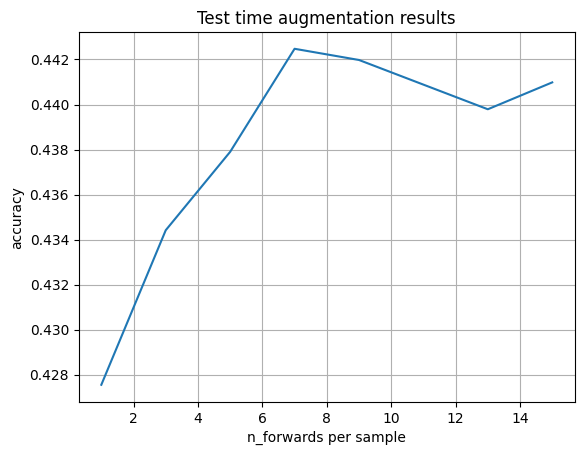

In [39]:
plt.plot(n_forwards, tta_accuracy)
plt.grid()
plt.xlabel('n_forwards per sample')
plt.ylabel('accuracy')
plt.title('Test time augmentation results')

Normally you should get 1-2% improvement of accuracy here.

## What's next?
Introducing of residual blocks played a big role in deep learning and allowed to train deep (and I mean really [DEEP](https://github.com/KaimingHe/resnet-1k-layers/blob/master/resnet-pre-act.lua#L2)) networks. Many modern architectures include such layer or its variation. For deeper understanding of influence of skip connections you can read the following papers:
1. ["Residual Networks Behave Like Ensembles of
Relatively Shallow Networks"](https://arxiv.org/pdf/1605.06431.pdf) - interesting point of view on residual blocks showing that statement "skip connections solves vanishing gradients problem" is ambigious in some way
2. ["Identity Mappings in Deep Residual Networks"](https://arxiv.org/pdf/1603.05027.pdf) ([short summary](https://towardsdatascience.com/resnet-with-identity-mapping-over-1000-layers-reached-image-classification-bb50a42af03e)) - study and comparison of different residual blocks variations showing that preserving "identity path" through the network improves quality
3. ["Visualizing the Loss Landscape of Neural Nets"](https://arxiv.org/pdf/1712.09913.pdf) - some attempts on loss function visualization showed how skip-connections affect loss landscape